# Task 2 ：Add noise for each type of attack to validate the effectiveness of the method.
Result download：https://huggingface.co/datasets/JimXie/IIoTset/blob/main/performance.tar.gz
1. Test the model's noise resistance using 46 features.
2. Test the model's noise resistance using 4 features.

In [1]:
import os,json,sys,logging
sys.path.append("./share")
sys.path.append("./common")
sys.path.append("./ml")
import pandas as pd
import json
from tqdm.notebook import tqdm
from IoTCommon import CIoTCommon
from IoTTotalFeature import CIoTTotalFeature
from IoTSample import CIoTSample
from SHSample import CSHSample
from SHDataProcess import CSHDataProcess
from SHFeatureSelect import CSHFeature
from Config import g_data_root,get_attack_score
from SHDataEDA import CSHDataDistribution,CSHDataTest
from SHModelRegression import CSHModelRegression
from SHModelClassify import CSHModelClassify
from IoTScore import CIoTScore,CIoTScoreTest,Create_Score_Sample,Create_Normal_Sample
from IoTDatabase import CIoTDbSample
from IoTNoise import CIoTNoise
import warnings
import h2o,re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Config import g_data_root
from datetime import datetime
warnings.simplefilter("ignore")
g_token_root = "%stoken/"%g_data_root
g_tmp_root = "%stmp/"%g_data_root
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,19 hours 29 mins
H2O_cluster_timezone:,Asia/Shanghai
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,3 months and 5 days
H2O_cluster_name:,H2O_from_python_jim_e13pc8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,788 Mb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


# Data preprocess

In [2]:
def is_valid_ip(ip_str):
    ip_pattern = re.compile(r'^((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$')
    if ip_pattern.match(ip_str):
        octets = ip_str.split('.')
        for octet in octets:
            if int(octet) > 255:
                return False
        return True
    else:
        return False
def is_valid_time(time_str):
    tmp = time_str.strip()
    tmp = tmp[:-3]
    try:
        datetime.strptime(tmp, '%Y %H:%M:%S.%f')
        return True
    except ValueError:
        return False

In [3]:
df = pd.read_csv("%s/raw/Selected dataset for ML and DL/ML-EdgeIIoT-dataset.csv"%g_data_root,low_memory=False)

In [4]:
def pre_process(x):
    ret = "ok"
    if not is_valid_time(x['frame.time']):
        ret = "frame.time"
    elif not is_valid_ip(x['ip.src_host']) and not is_valid_ip(x['arp.src.proto_ipv4']):
        ret = "src_host"
    elif not is_valid_ip(x['ip.dst_host']) and not is_valid_ip(x['arp.dst.proto_ipv4']):
        ret = "dst_host"
    return ret
    
df['flag'] = df.progress_apply(pre_process,axis=1)
df = df[df['flag'] == "ok"]

del df['frame.time']
del df['ip.src_host']
del df['ip.dst_host']
del df['arp.src.proto_ipv4']
del df['arp.dst.proto_ipv4']
del df['tcp.srcport']
del df['tcp.dstport']
del df['udp.port']
del df['tcp.payload']
del df['http.tls_port']
del df['http.file_data']
del df['icmp.transmit_timestamp']
del df['http.request.uri.query']
del df['http.referer']
del df['http.request.full_uri']
del df['http.request.version']
del df['tcp.options']
del df['dns.qry.name.len']
del df['mqtt.msg']

one_hot_encoded = pd.get_dummies(df['http.request.method'],prefix='http.request.method')
df = pd.concat([df, one_hot_encoded], axis=1)
#one_hot_encoded = pd.get_dummies(df['mqtt.conack.flags'],prefix='mqtt.conack.flags')
#df = pd.concat([df, one_hot_encoded], axis=1)
#one_hot_encoded = pd.get_dummies(df['mqtt.protoname'],prefix='mqtt.protoname')
#df = pd.concat([df, one_hot_encoded], axis=1)
#one_hot_encoded = pd.get_dummies(df['mqtt.topic'],prefix='mqtt.topic')
#df = pd.concat([df, one_hot_encoded], axis=1)

del df['http.request.method']
del df['mqtt.conack.flags']
del df['mqtt.protoname']
del df['mqtt.topic']
df['Attack_type']=df['Attack_type'].astype(dtype='category')
df['Attack_code']=df['Attack_type'].cat.codes

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157800/157800 [00:12<00:00, 12536.03it/s]


In [5]:
def get_base(attack):
    df_base = df.copy(deep=True)
    df_base = df[df['Attack_type'].isin([attack,'Normal'])]
    del df_base['Attack_type']
    del df_base['flag']
    del df_base['Attack_code']
    for key in df_base.columns:
        if df_base[key].nunique() <= 1:
            del df_base[key]
    col_y = "Attack_label"
    col_x = []
    for col in df_base.columns.tolist():
        if not col == col_y:
            col_x.append(col)
    return df_base,col_x,col_y
    
def get_normal_sample(attack):
    df_base,col_x,col_y = get_base(attack)
    df_data = CSHSample.resample_smote(df_base,x_columns=col_x,y_column=col_y)
    df_tmp = df_data.copy(deep = True)
    scale_colums = []
    for key,type in zip(df_tmp.keys(),df_tmp.dtypes):
        if not type in ["bool","object","category"] and not key in [col_y]:
            scale_colums.append(key)
        if df_tmp[key].dtype =='bool':
            df_tmp[key] = df_tmp[key].astype(int)
    for key in scale_colums:
        df_tmp[key] = (df_tmp[key]-df_tmp[key].min())/(df_tmp[key].max()-df_tmp[key].min()) + 1
        df_tmp[key],l = CSHDataProcess.normal_transform(df_tmp[key])
    df_train,df_test = CSHSample.split_dataset(df_tmp)
    return df_train,df_test,col_x,col_y

def add_noise(df_input,ratio=0.1):
    df_data = df_input.copy(deep = True)
    for feature in df_data.keys().tolist():
        if feature in ['Attack_label']:
            continue
        dtypes_dict = df_input.dtypes.to_dict()
        type = dtypes_dict[feature]
        df_data[feature] = CIoTNoise.add_noise(feature,type,df_data,ratio)
    return df_data

def train_test(df_train,df_test,col_x,col_y):
    model = CSHModelClassify()
    model.train(df_train,x_columns=col_x,y_column=col_y,train_ratio = 0)
    df_importance = model.importance()
    df_result = pd.DataFrame()
    df_verify = model.evaluate(df_test,x_columns=col_x,y_column=col_y)
    df_verify['ratio'] = 0
    df_result = df_verify
    for ratio in tqdm([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]):
        df_test_noised = add_noise(df_test,ratio=ratio)
        df_verify_noised = model.evaluate(df_test_noised,x_columns=col_x,y_column=col_y)
        df_verify_noised['ratio'] = ratio
        df_result = pd.concat([df_result,df_verify_noised],ignore_index=True)
    df_result = df_result.reset_index(drop=True)
    return df_importance,df_result

# Train models for each attack and validate performance under different noise ratios.

In [6]:
h2o.connect()
df_importance = pd.DataFrame()
df_verify = pd.DataFrame()

for attack in df['Attack_type'].unique().tolist():
    if attack == "Normal":
        continue
    df_train,df_test,col_x,col_y = get_normal_sample(attack)
    df_importance1,df_verify1 = train_test(df_train,df_test,col_x,col_y)
    df_verify1['attack'] = attack
    df_importance1['attack'] = attack
    df_verify1['kind'] = '46-Features'
    df_importance1['kind'] = '46-Features'
    df_importance = pd.concat([df_importance,df_importance1],ignore_index=True)
    df_verify = pd.concat([df_verify,df_verify1],ignore_index=True)

df_importance = df_importance.reset_index(drop=True)
df_verify = df_verify.reset_index(drop=True)
df_importance.to_csv("./IIoTSet/result/attack-importance.csv")
df_verify.to_csv("./IIoTSet/result/attack-performance.csv")

Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,3 hours 44 mins
H2O_cluster_timezone:,Asia/Shanghai
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,3 months and 4 days
H2O_cluster_name:,H2O_from_python_jim_e13pc8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.208 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
psvm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
naivebayes Model Build progress: |███████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

  0%|          | 0/10 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

  0%|          | 0/10 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

  0%|          | 0/10 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

  0%|          | 0/10 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

  0%|          | 0/10 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

  0%|          | 0/10 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

  0%|          | 0/10 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

  0%|          | 0/10 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

  0%|          | 0/10 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

  0%|          | 0/10 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

  0%|          | 0/10 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

  0%|          | 0/10 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

# Show experimental results

In [14]:
df_result = pd.read_csv("./IIoTSet/result/attack-performance.csv",index_col=0)
del df_result['confusion_matrix']
df_result = df_result[['model','recall','accuracy','precision','auc','f1_score','ratio','attack']]

In [15]:
df_result

,model,recall,accuracy,precision,auc,f1_score,ratio,attack
0,ann,0.96514513,0.96514513,0.96704357,0.96514513,0.96510967,0.00000000,Fingerprinting
1,bayes,0.89183825,0.89183825,0.89416946,0.89183825,0.89167809,0.00000000,Fingerprinting
2,dt,0.89258249,0.89258249,0.89500997,0.89258249,0.89241720,0.00000000,Fingerprinting
3,gbm,0.97482014,0.97482014,0.97530692,0.97482014,0.97481370,0.00000000,Fingerprinting
4,glm,0.96613743,0.96613743,0.96825382,0.96613743,0.96609913,0.00000000,Fingerprinting
...,...,...,...,...,...,...,...,...
1051,gbm,0.64946663,0.64946663,0.75851415,0.65010924,0.60852642,1.00000000,DDoS_ICMP
1052,glm,0.90895559,0.90895559,0.92264236,0.90877652,0.90819456,1.00000000,DDoS_ICMP
1053,rf,0.53832796,0.53832796,0.75328633,0.53741186,0.41312679,1.00000000,DDoS_ICMP
1054,svm,0.91478541,0.91478541,0.92050939,0.91466913,0.91448358,1.00000000,DDoS_ICMP


In [12]:
def show_result(df_result):
    for model in df_result['model'].unique():
        df_tmp = df_result[df_result['model']==model]
        del df_tmp['model']
        df_tmp = df_tmp.groupby('ratio').mean()
        df_tmp = df_tmp.sort_values(by='ratio').reset_index()
        df_long = pd.melt(df_tmp, 
                          id_vars=['ratio'], 
                          value_vars=['recall', 'precision','accuracy','f1_score'], 
                          var_name='metric', value_name='value')
        sns.barplot(x='ratio', y='value',hue='metric',orient='v',ci=None,data=df_long)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.110), ncol=4)
        plt.xlabel('Noise ratio', fontsize=10)
        plt.ylabel('Metric value', fontsize=10)
        plt.title('Performance of %s'%model, fontsize=12)
        plt.show()

Backdoor


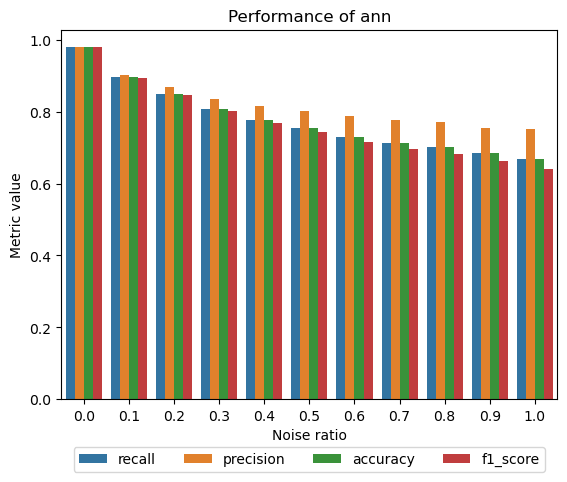

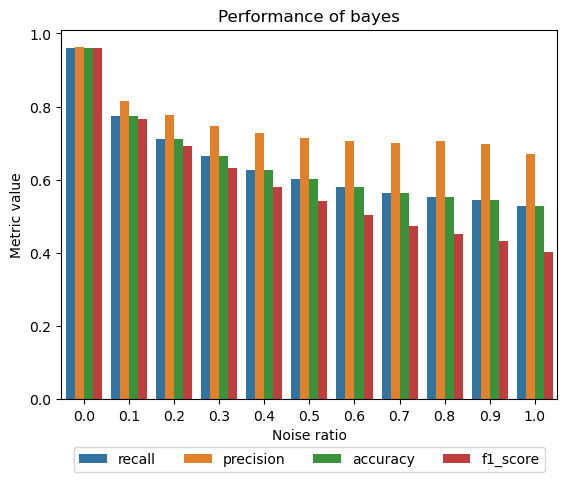

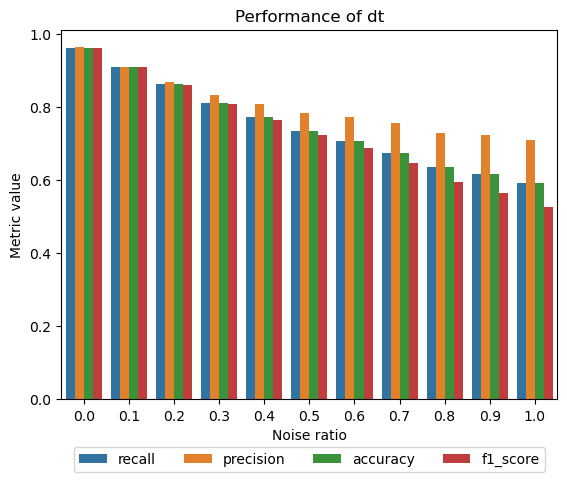

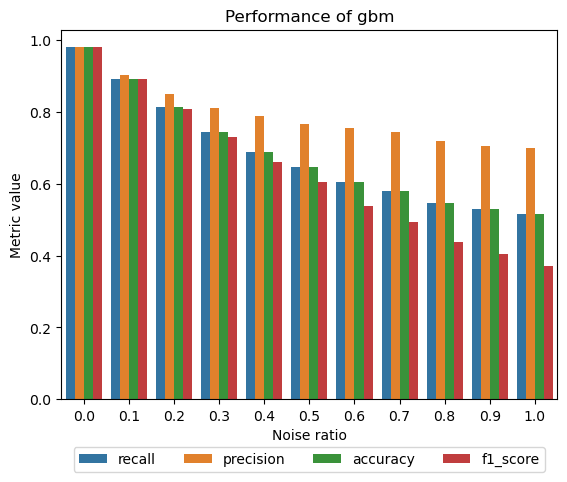

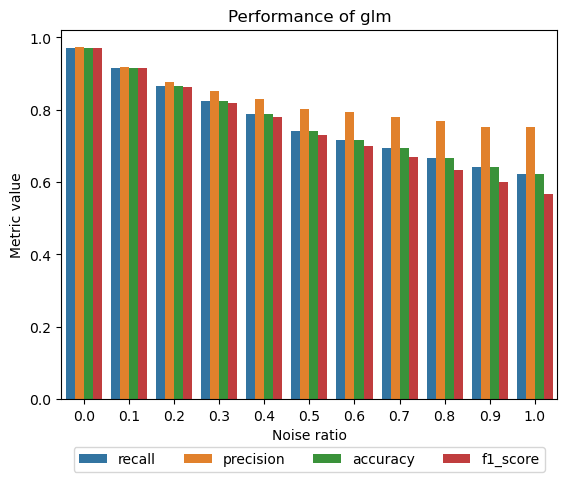

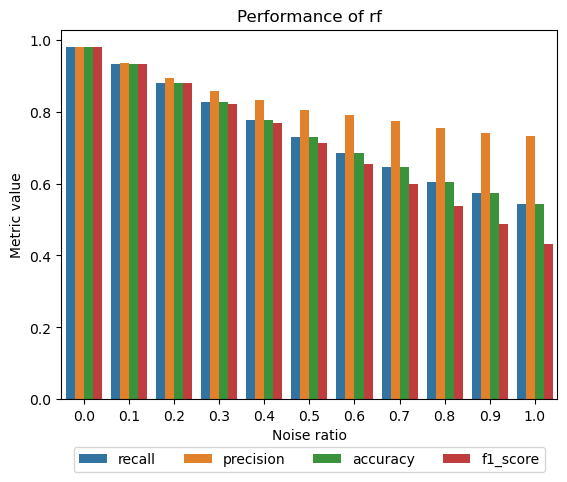

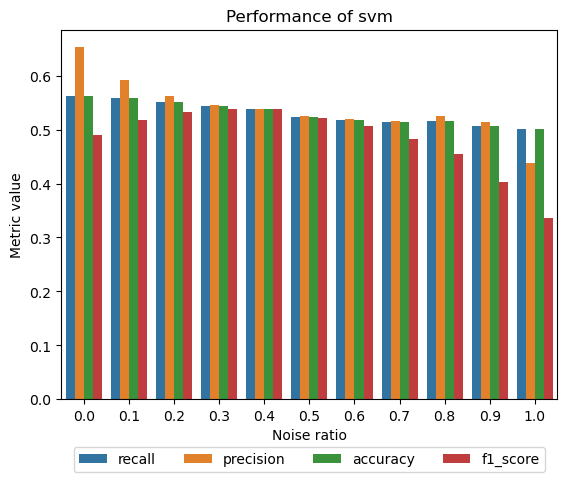

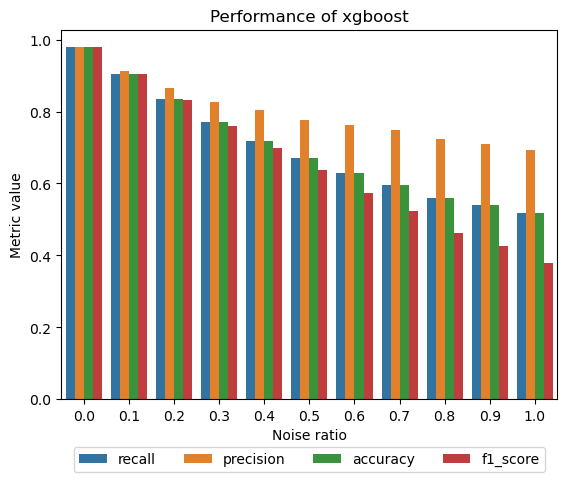

DDoS_HTTP


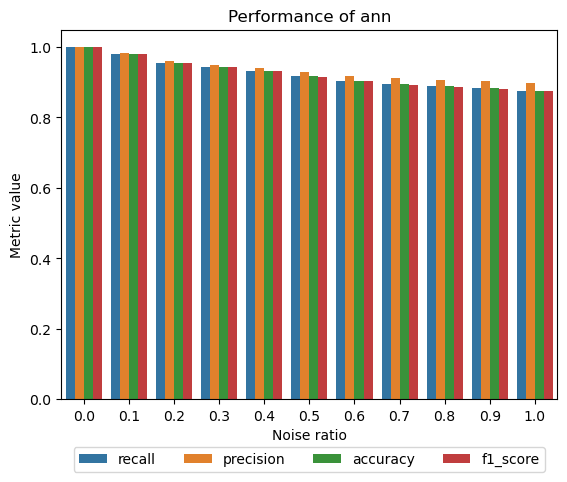

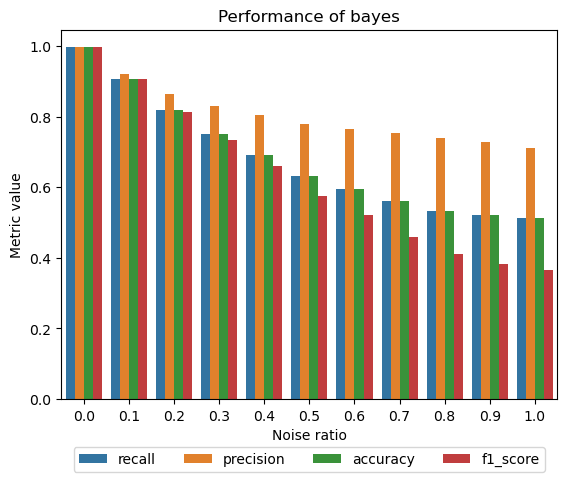

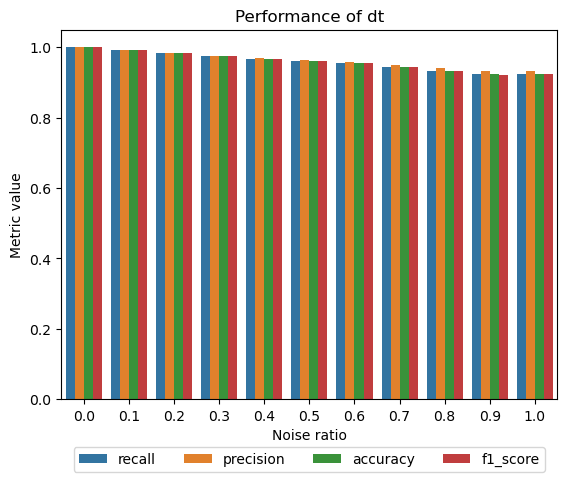

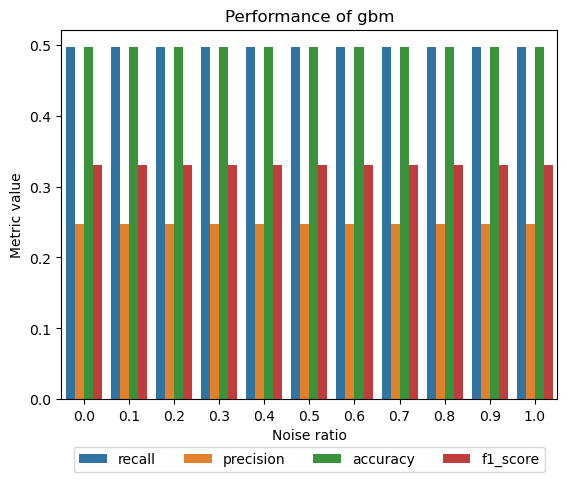

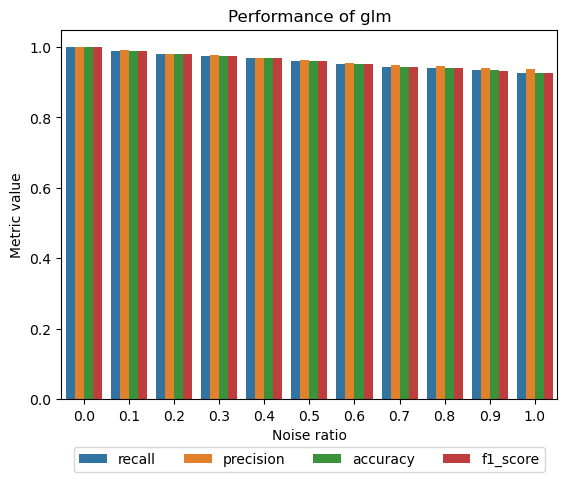

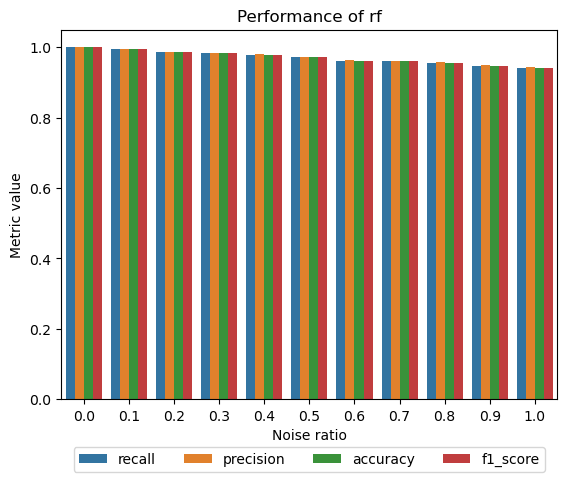

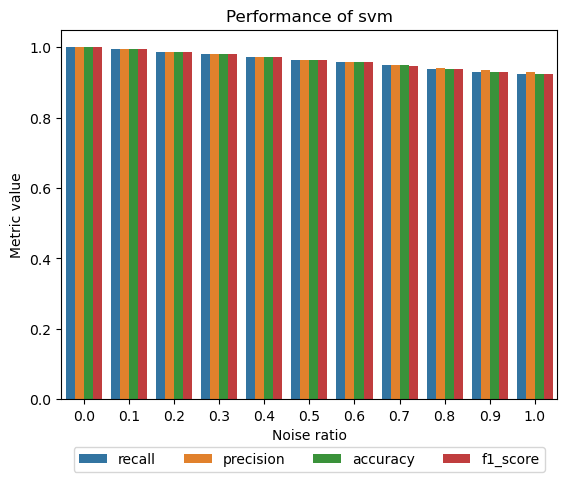

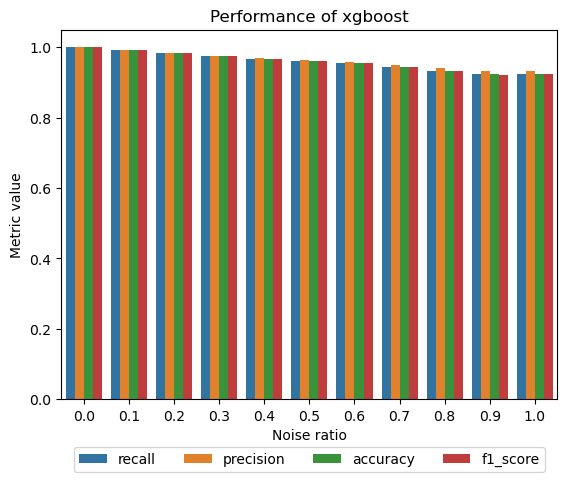

DDoS_ICMP


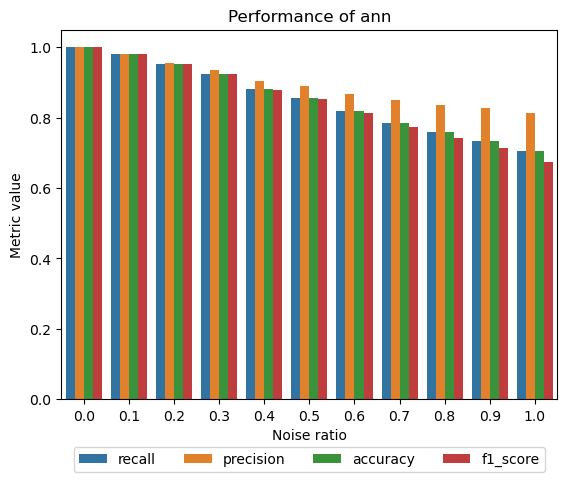

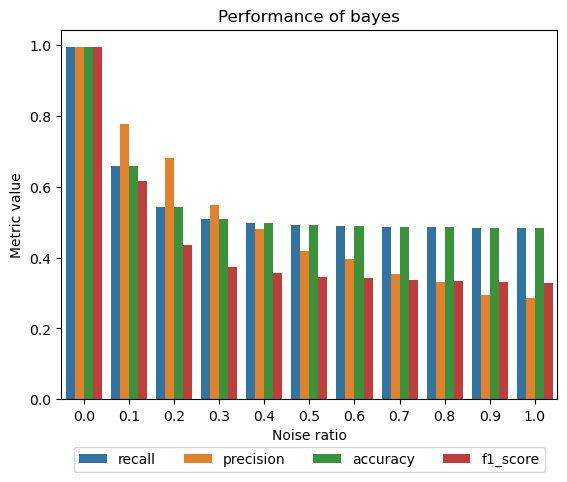

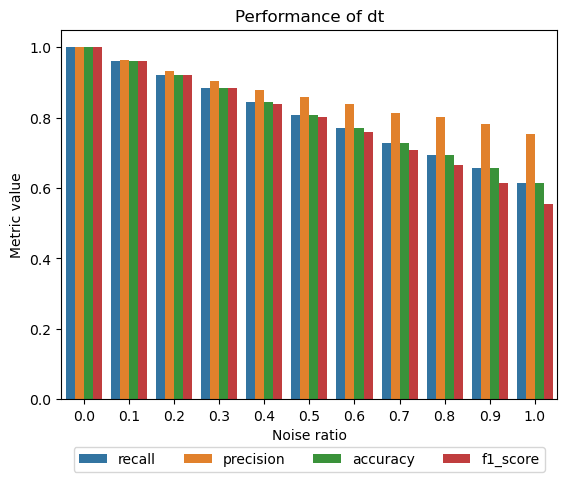

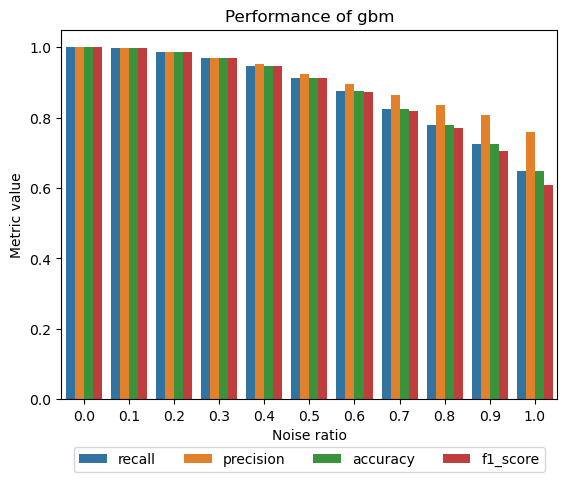

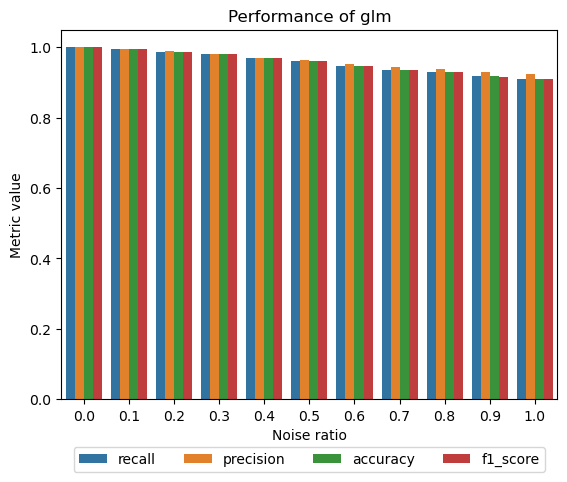

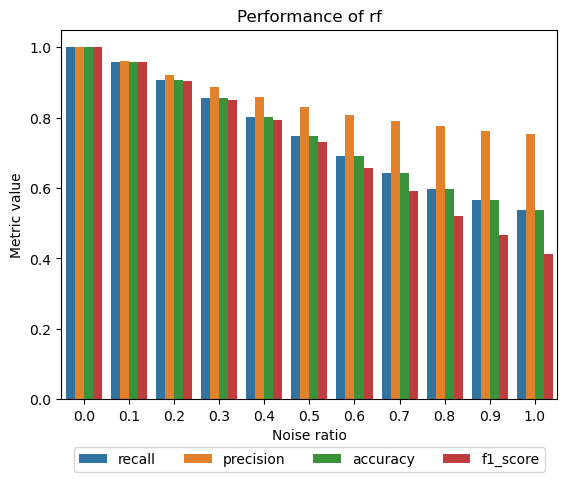

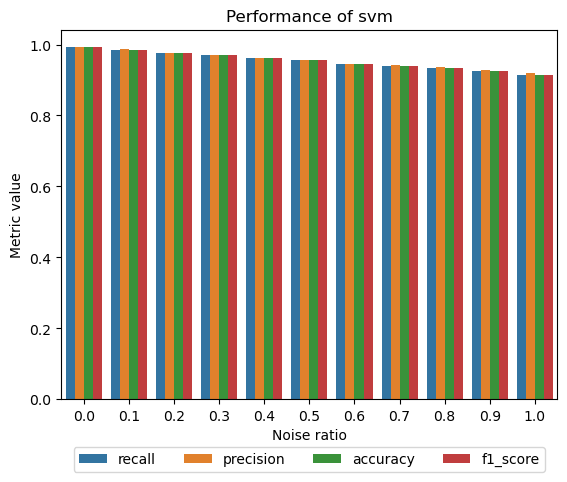

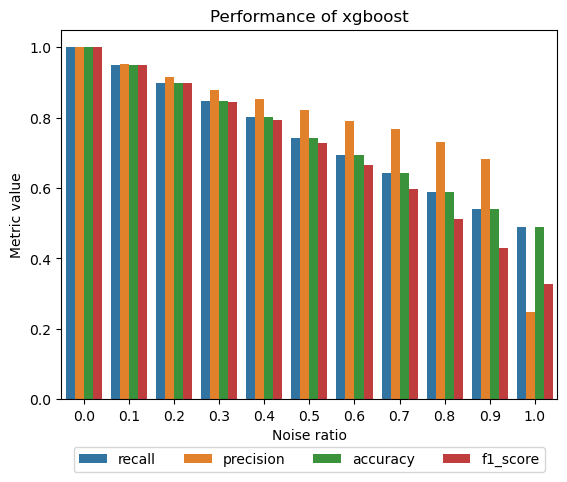

DDoS_TCP


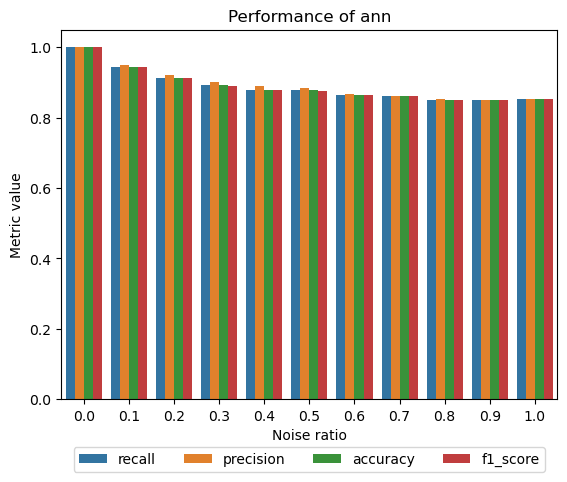

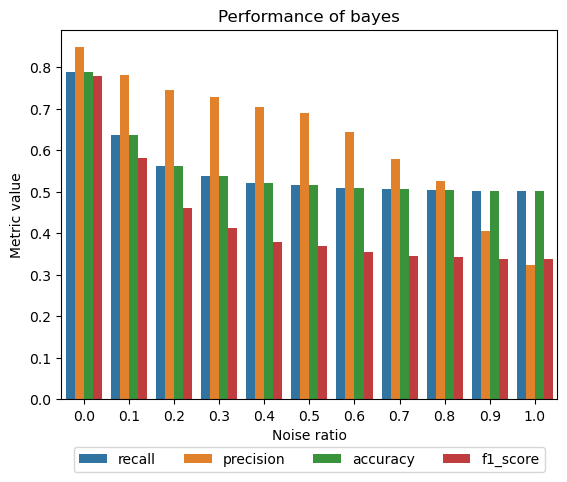

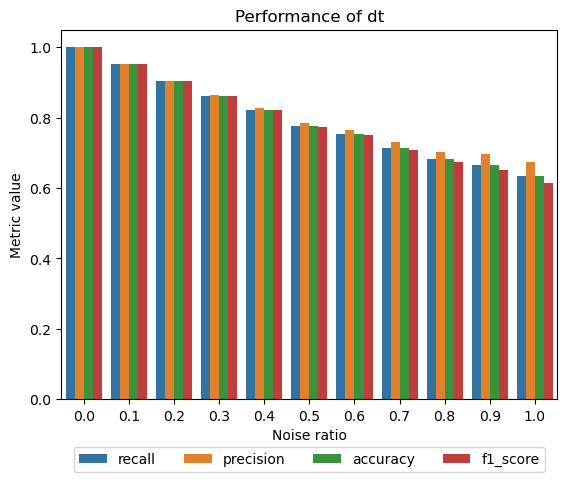

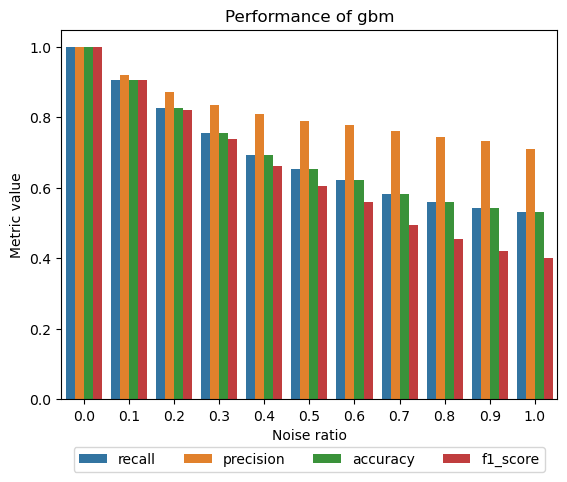

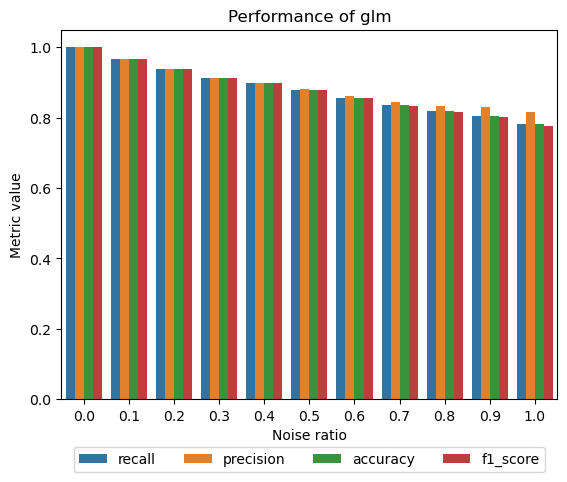

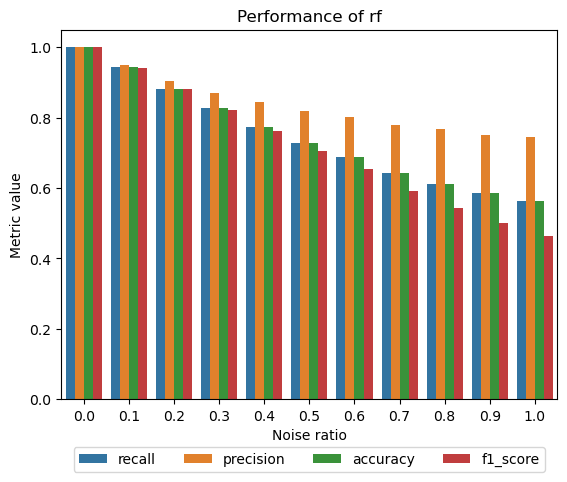

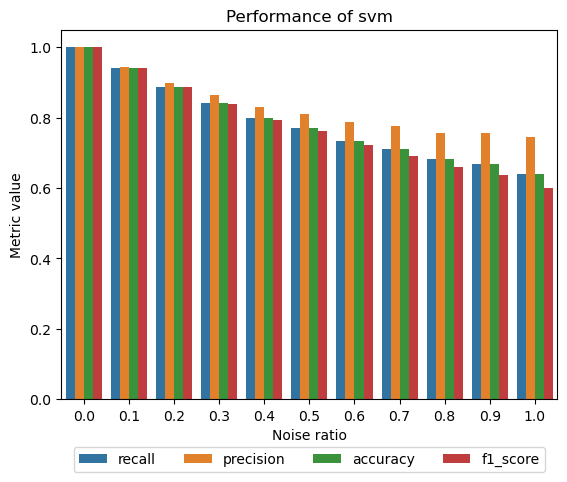

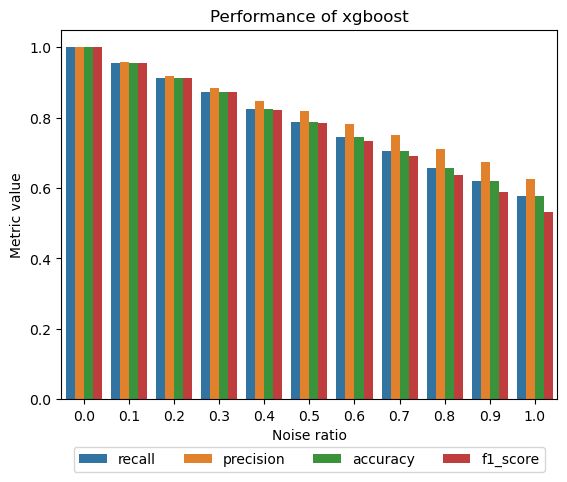

Fingerprinting


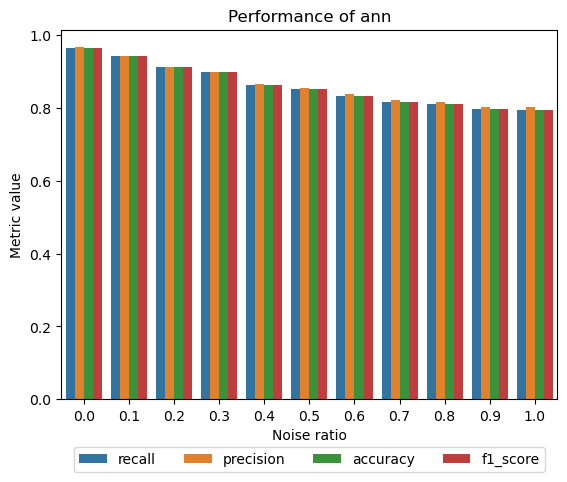

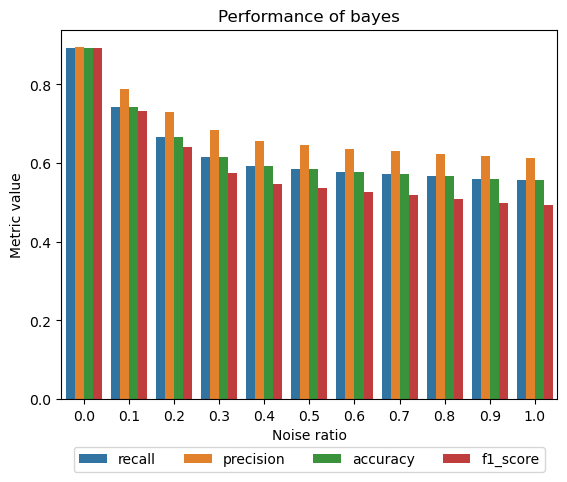

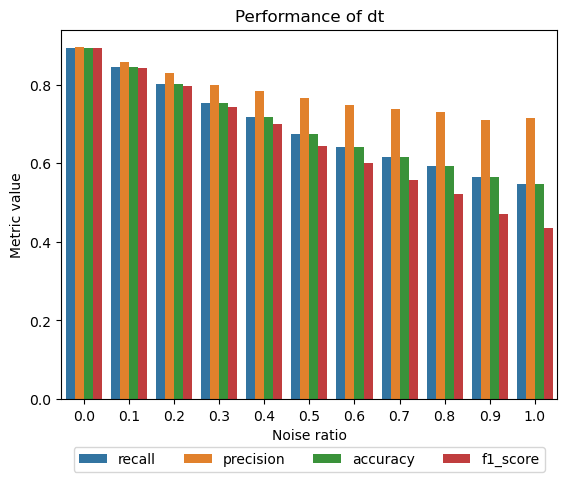

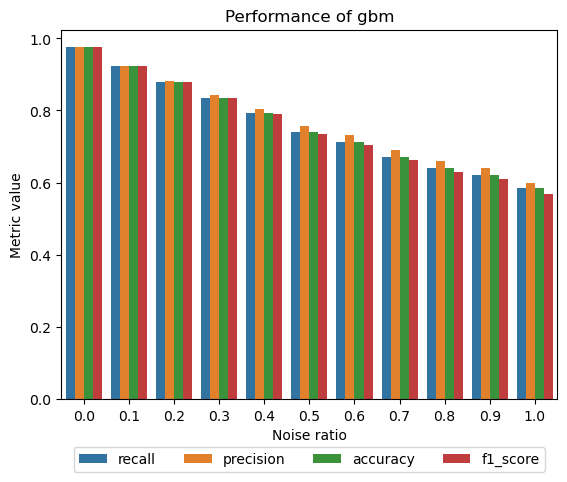

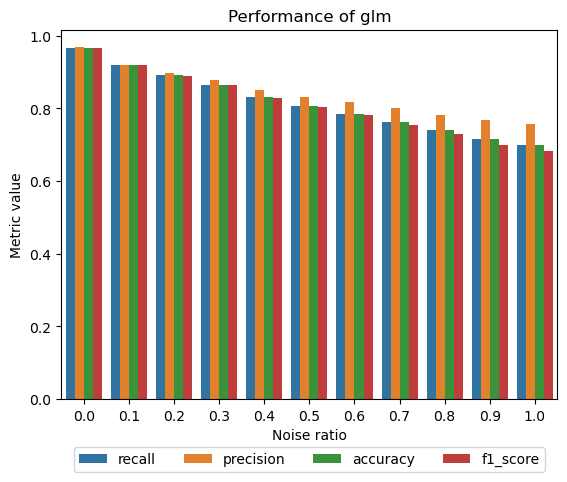

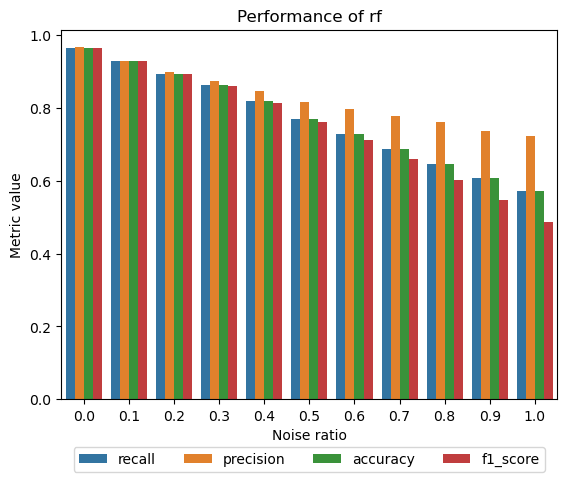

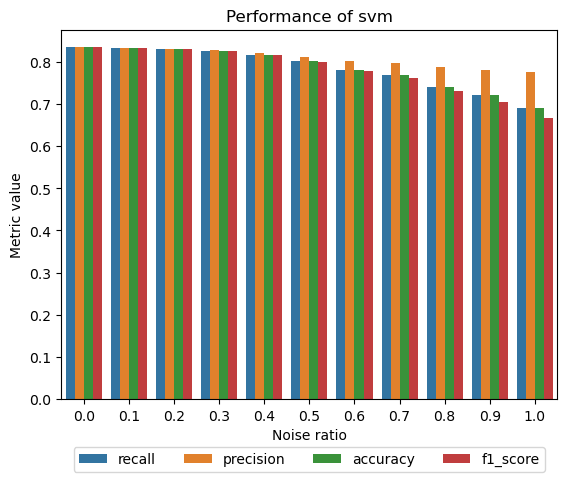

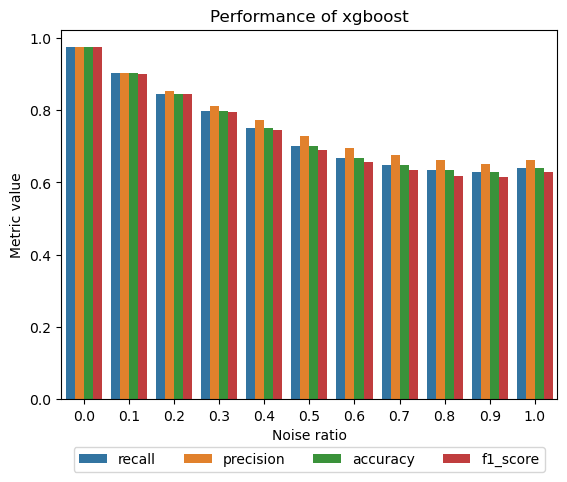

Password


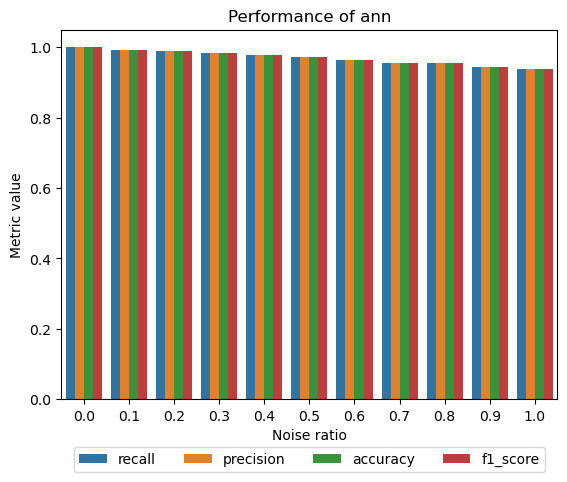

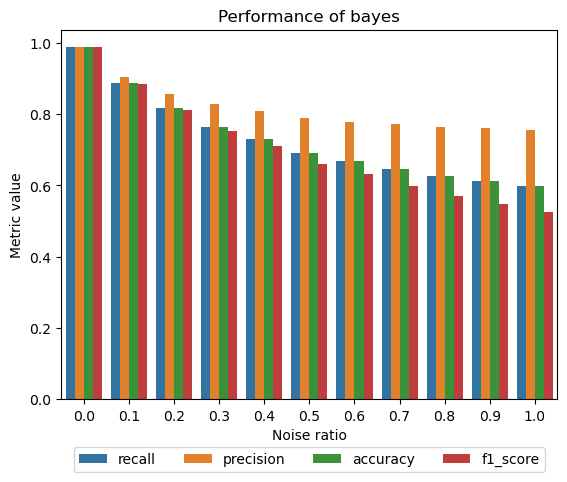

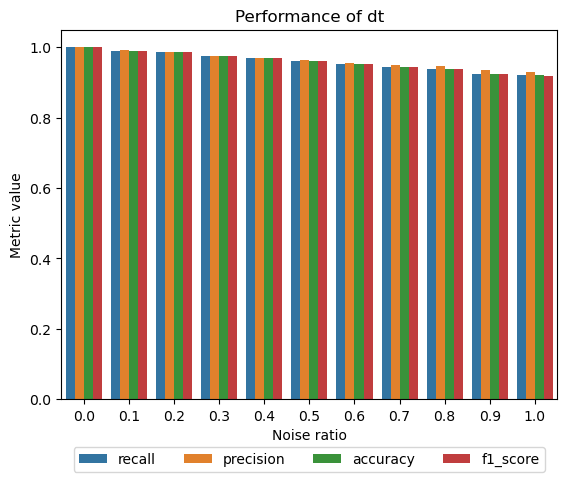

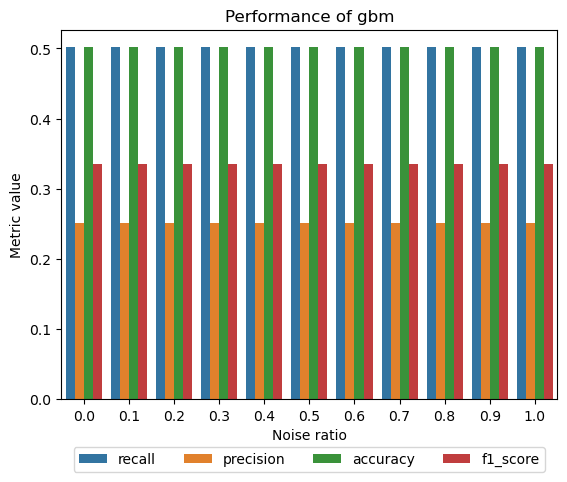

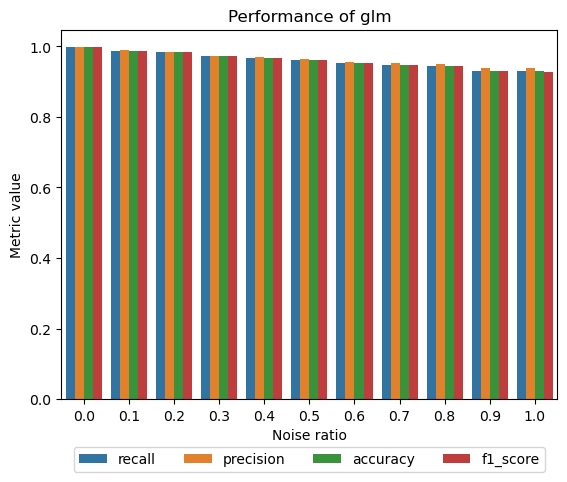

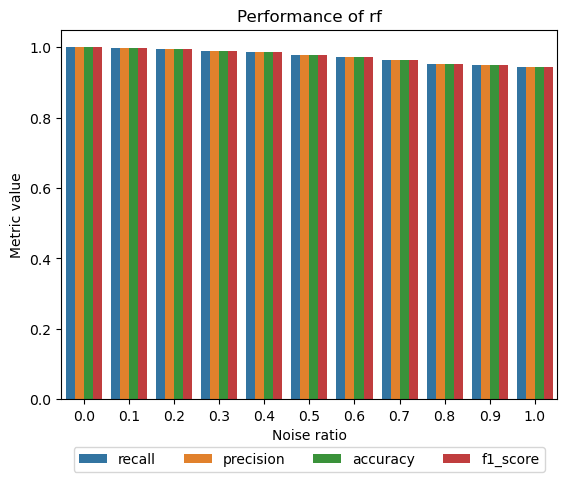

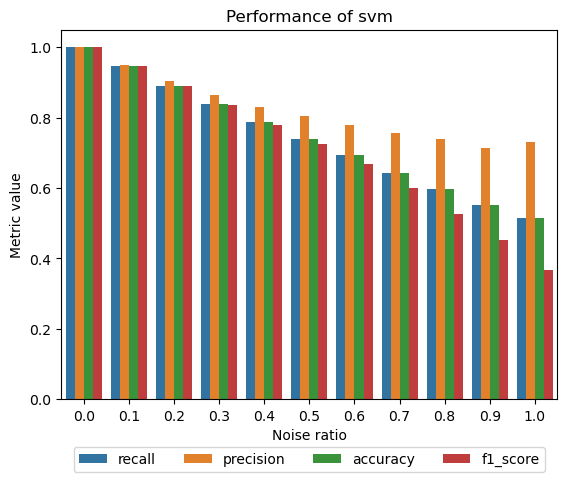

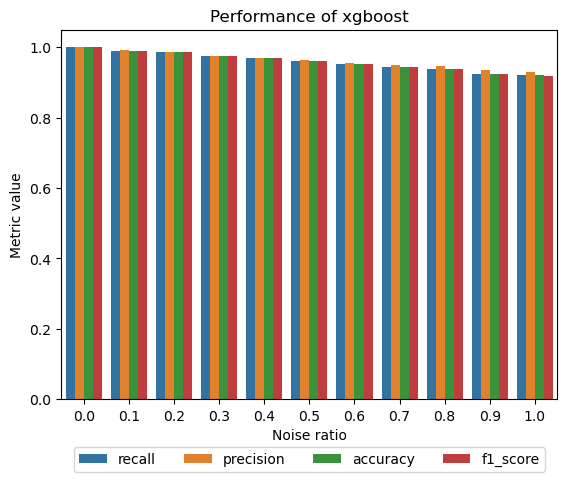

Port_Scanning


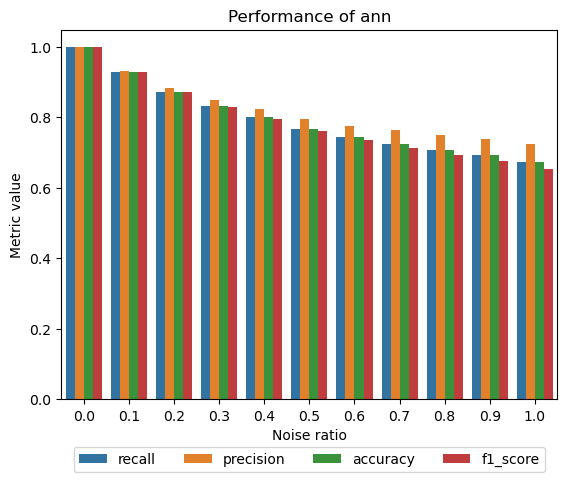

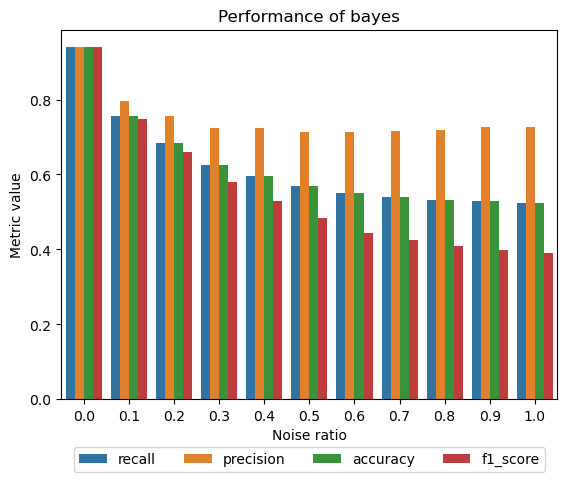

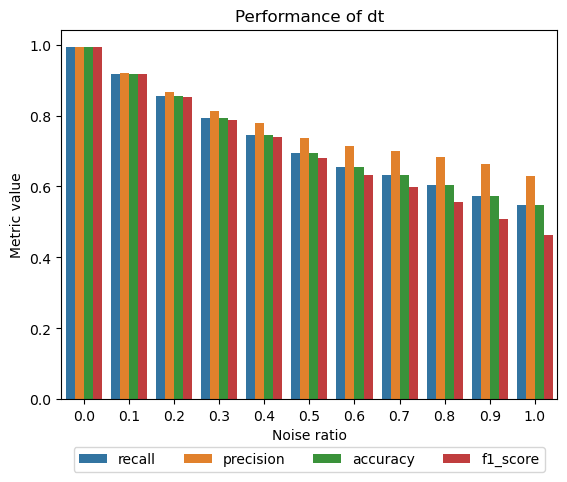

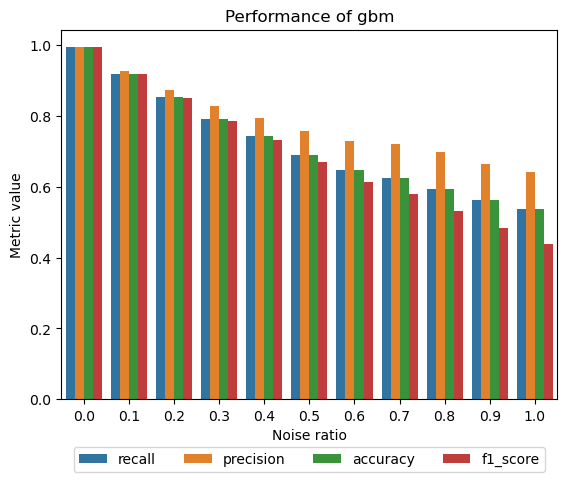

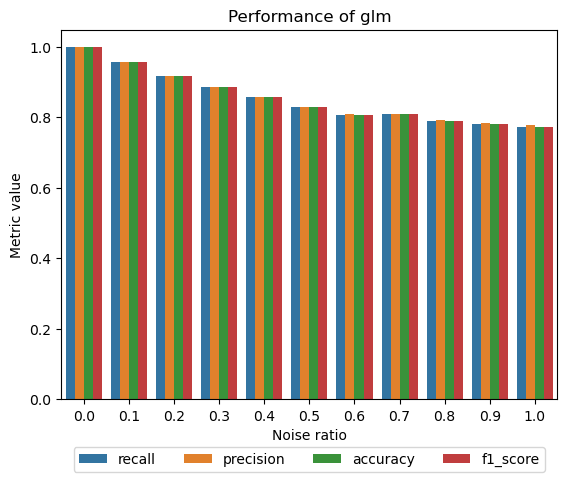

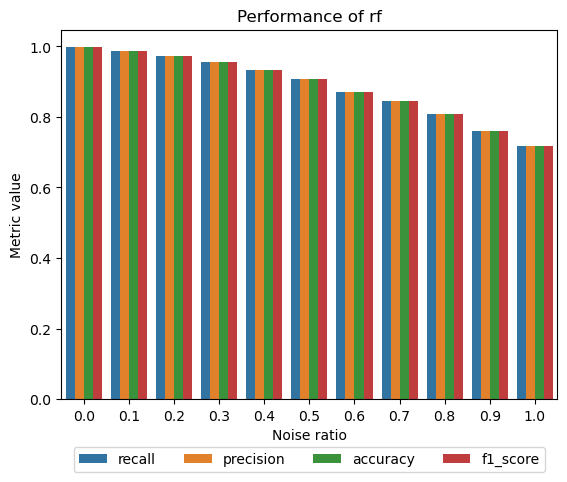

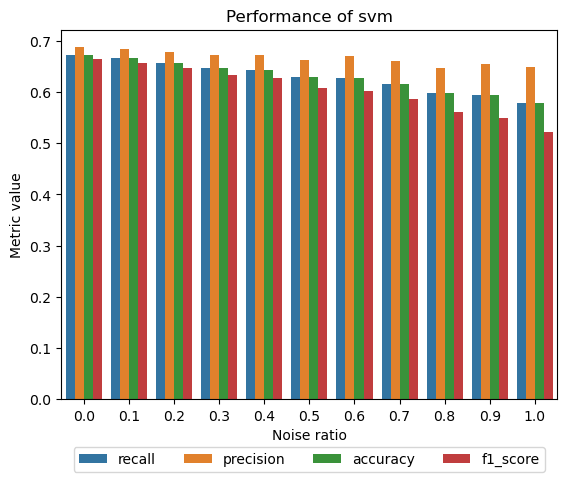

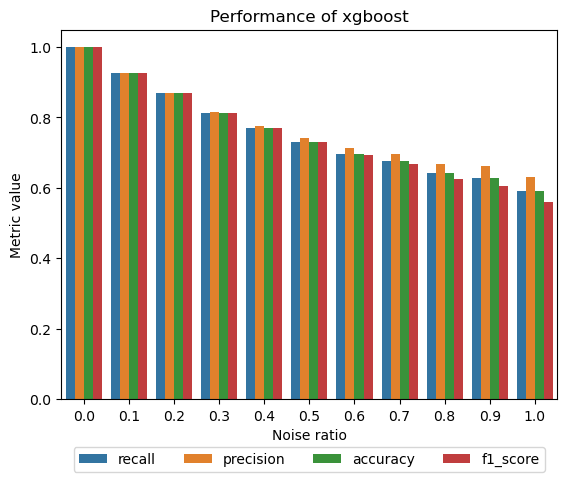

Ransomware


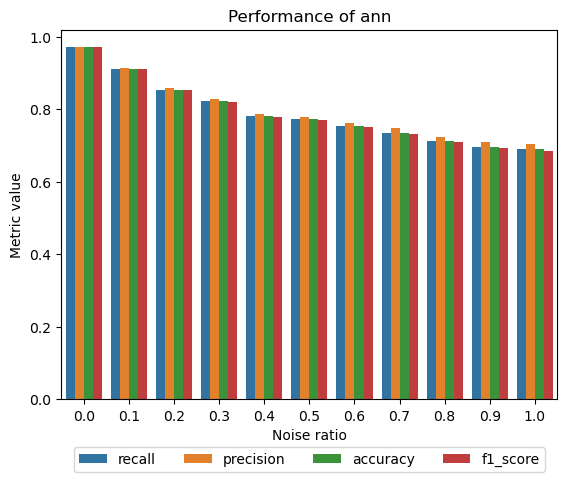

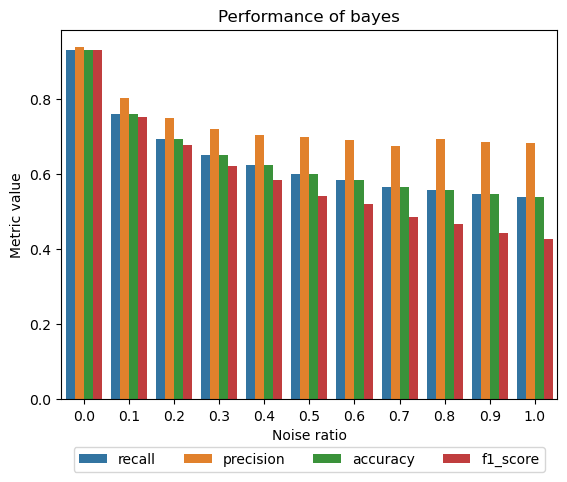

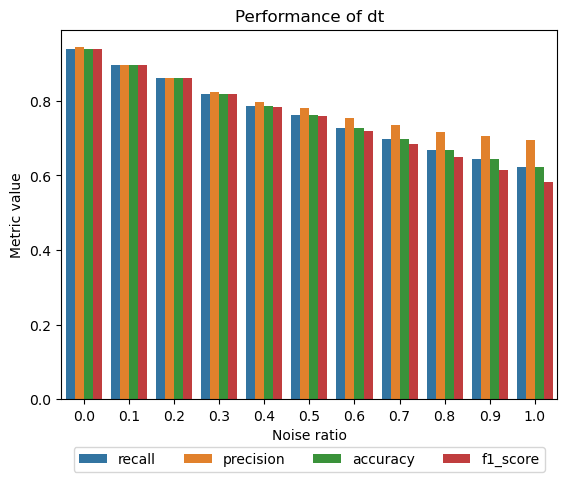

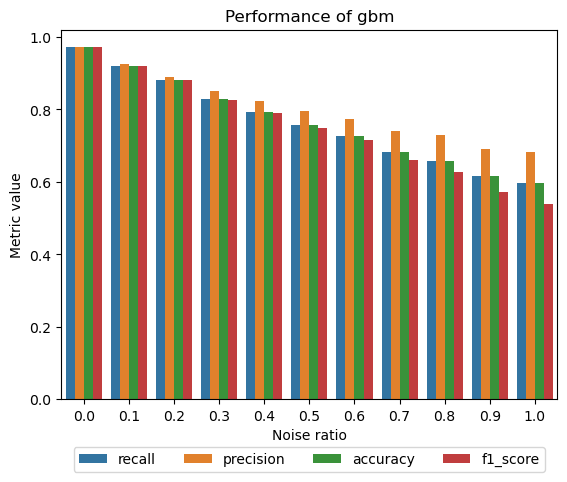

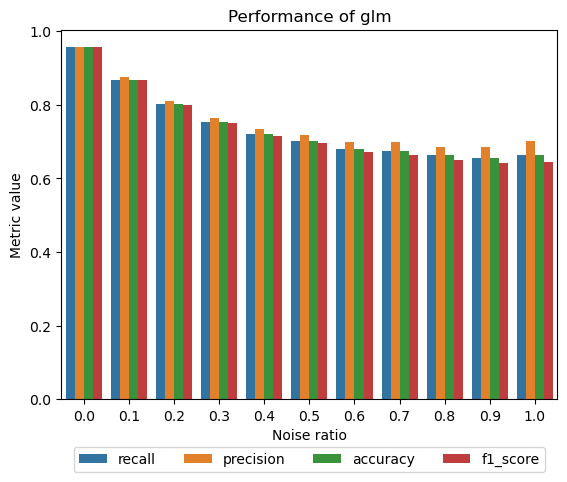

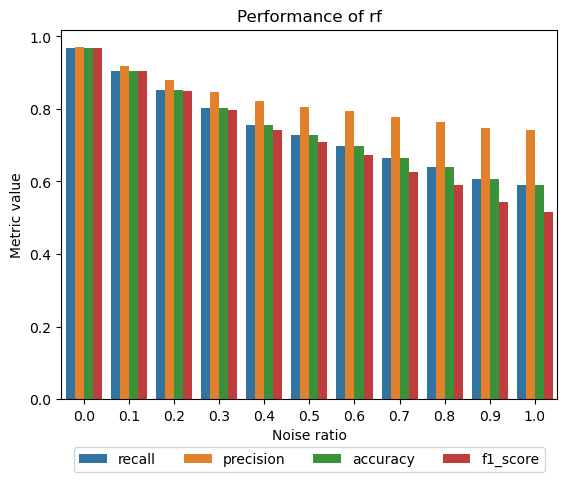

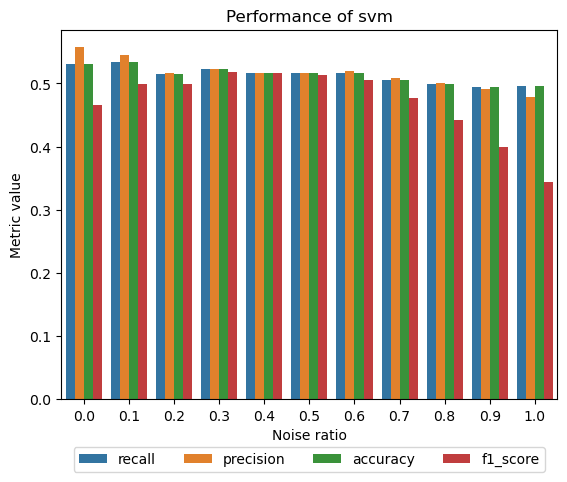

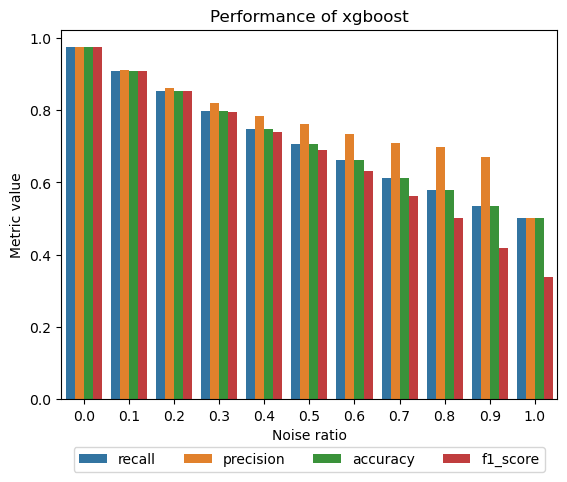

SQL_injection


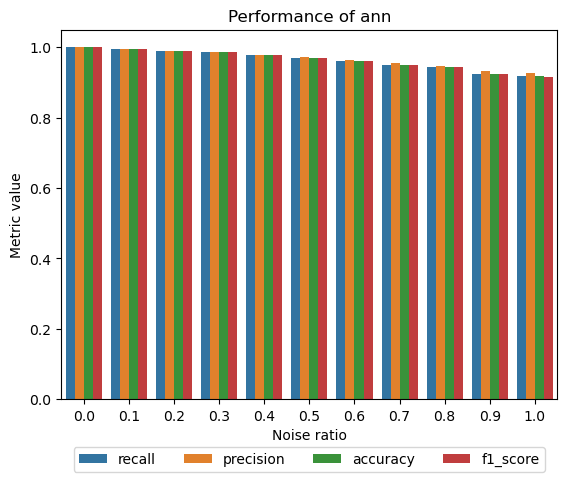

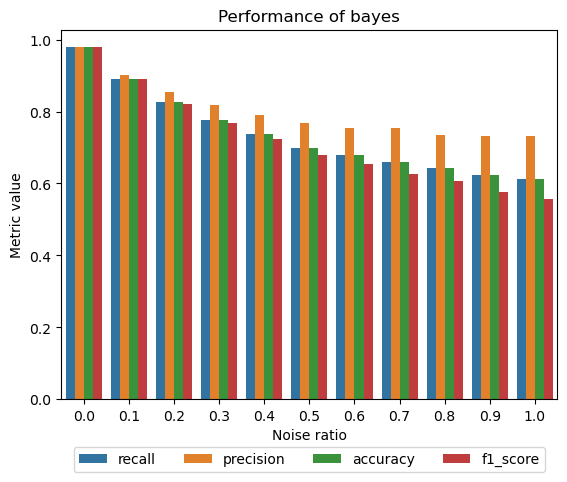

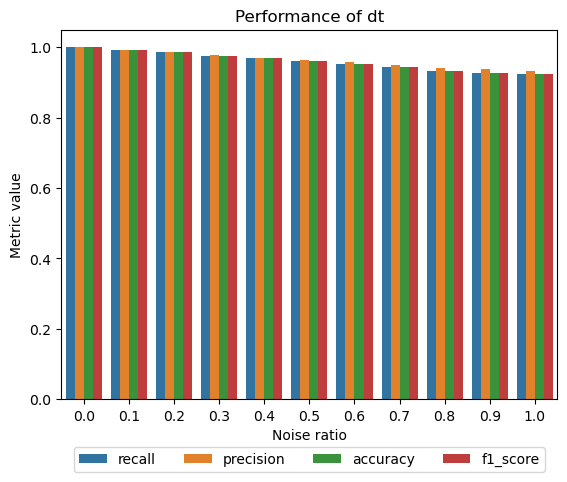

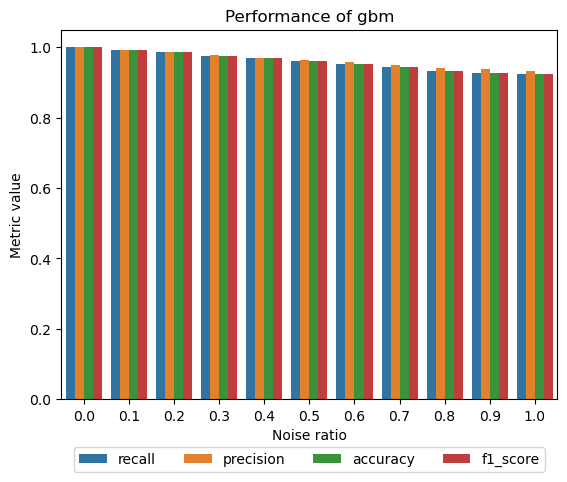

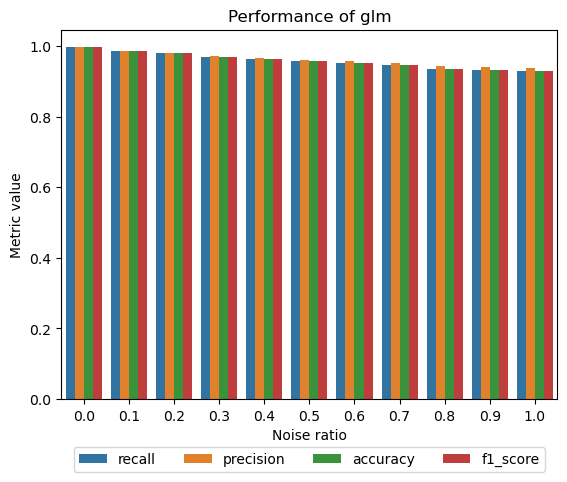

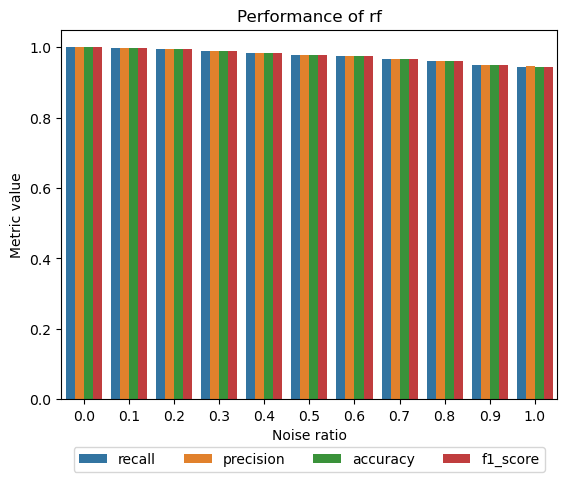

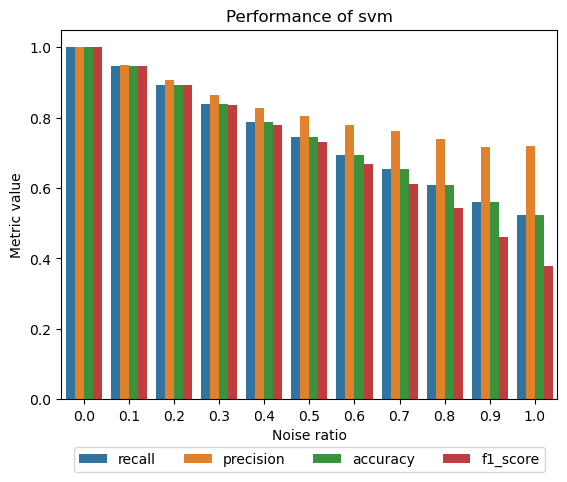

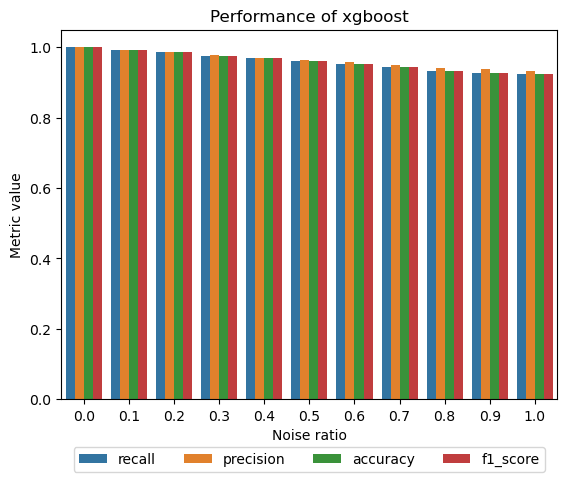

Uploading


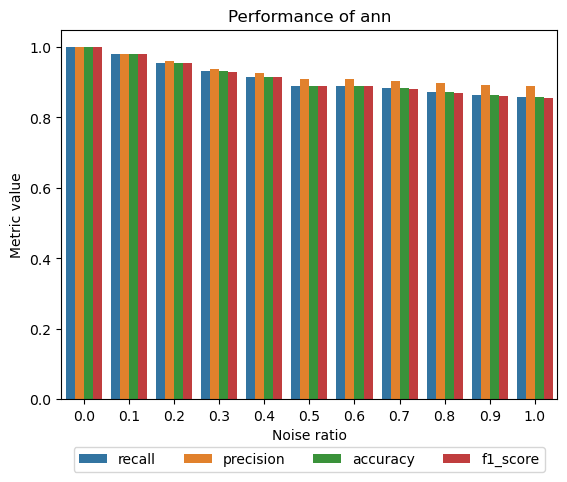

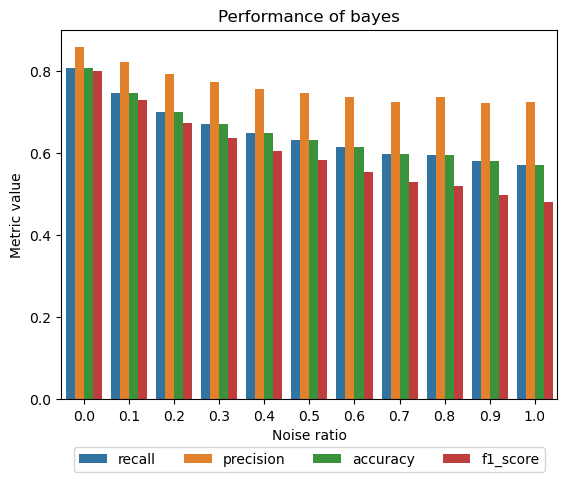

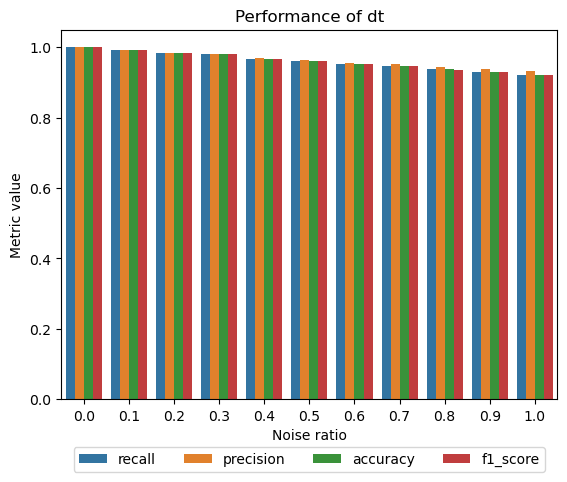

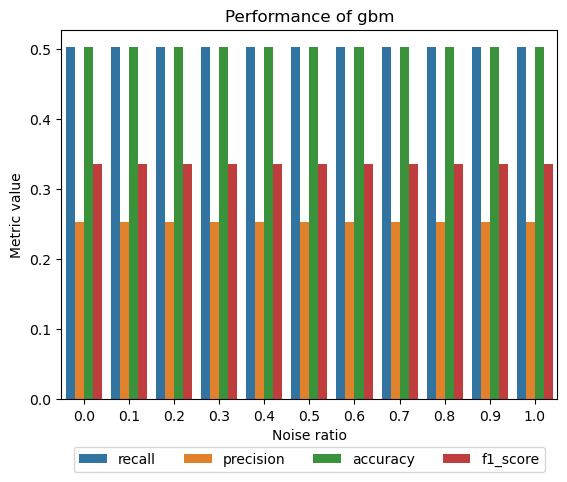

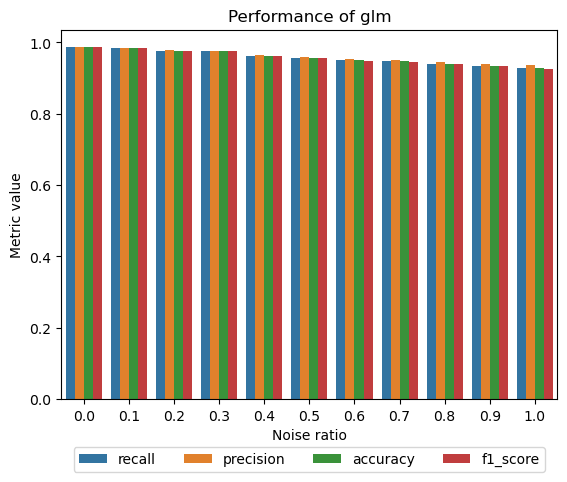

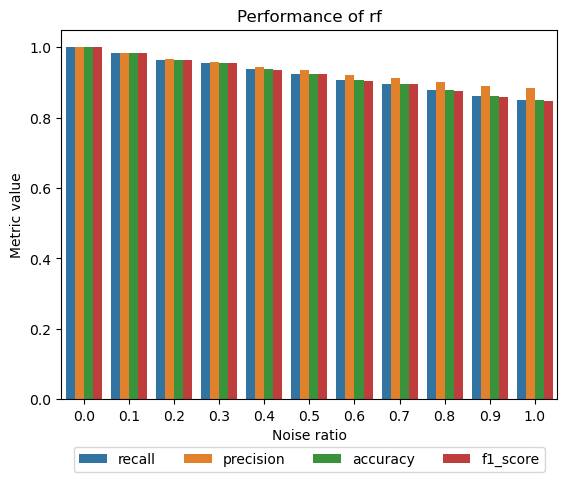

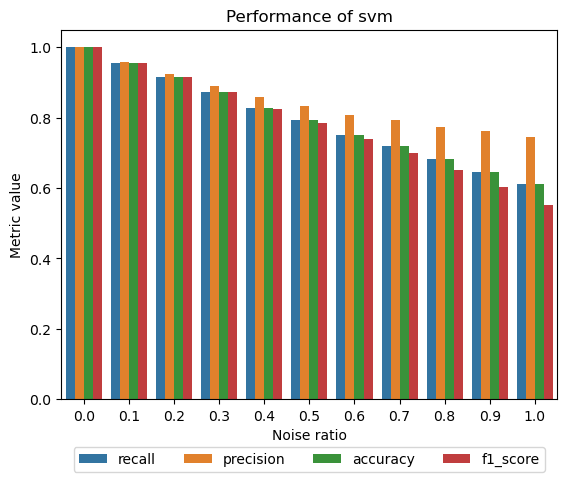

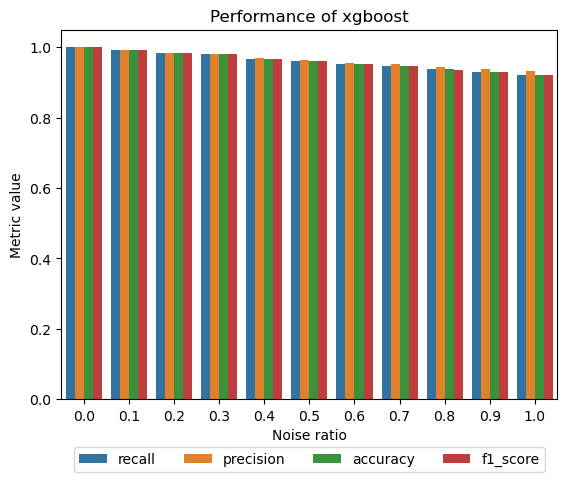

Vulnerability_scanner


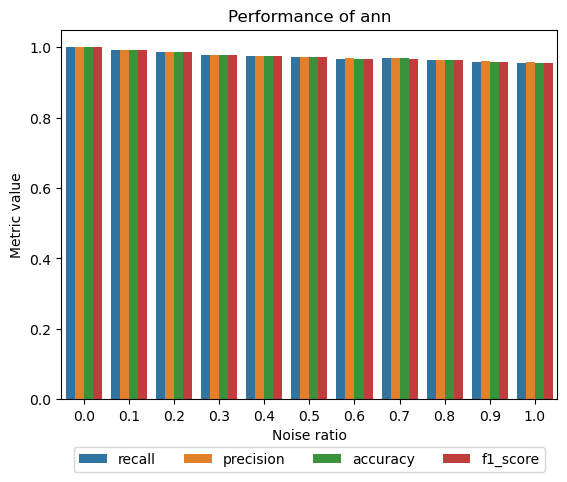

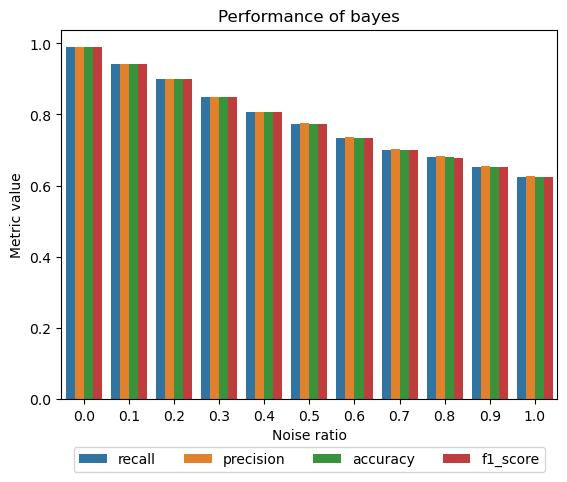

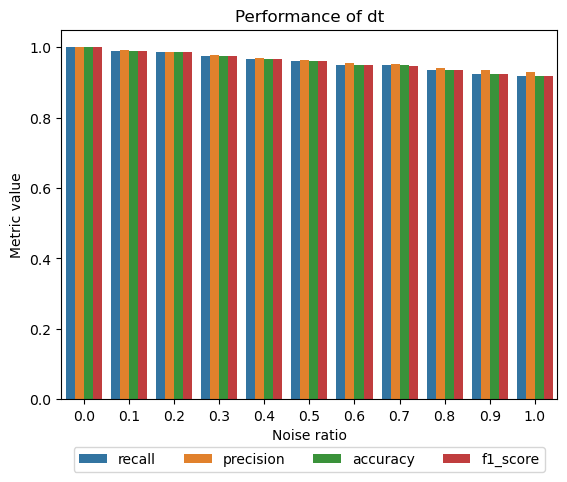

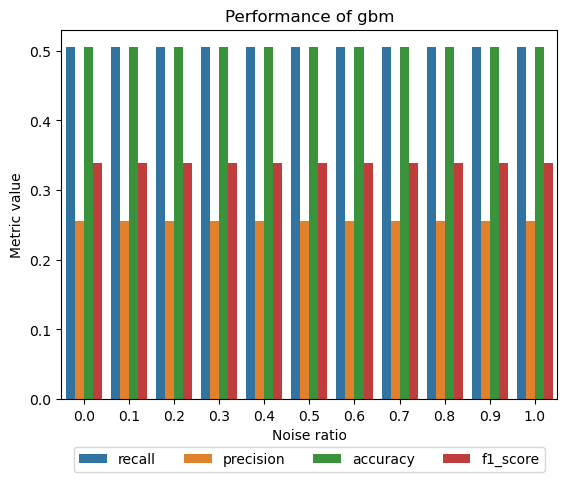

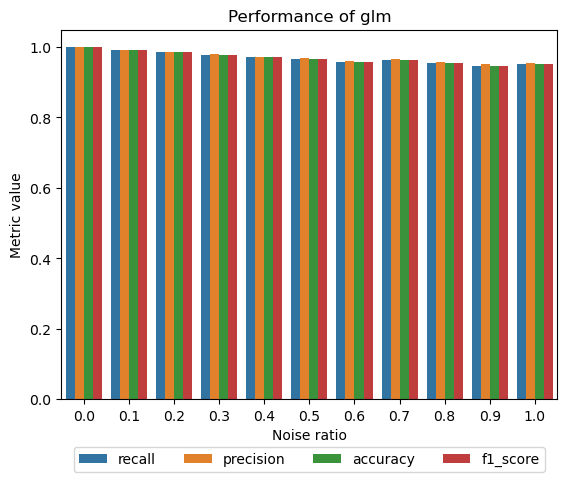

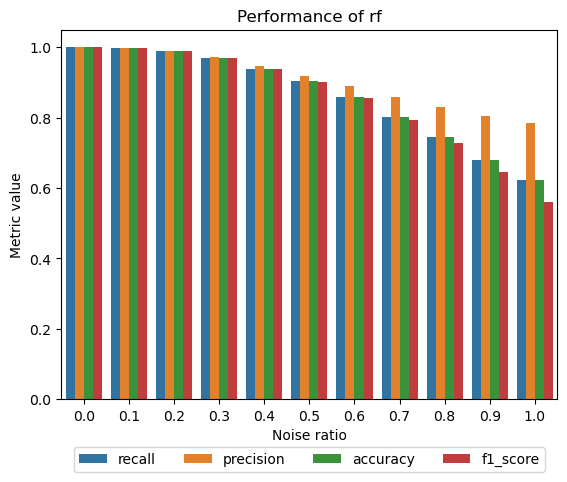

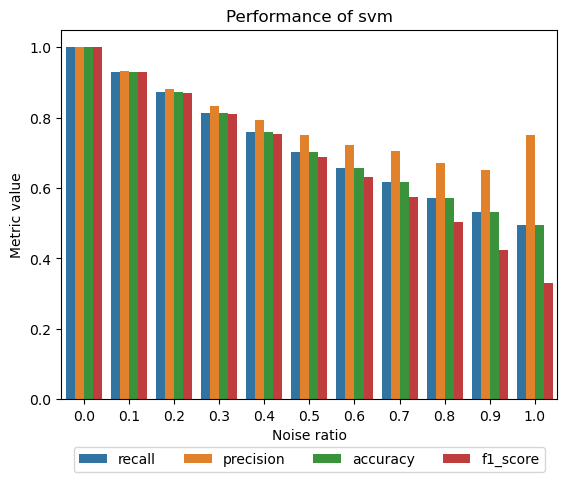

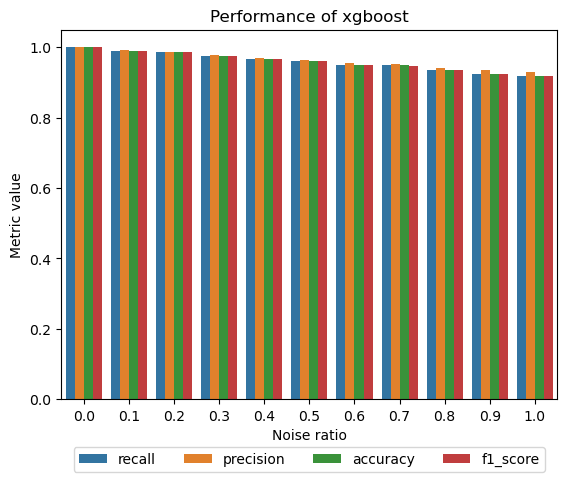

XSS


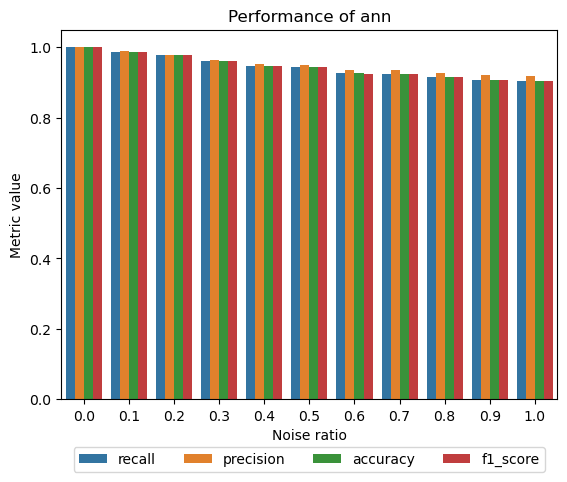

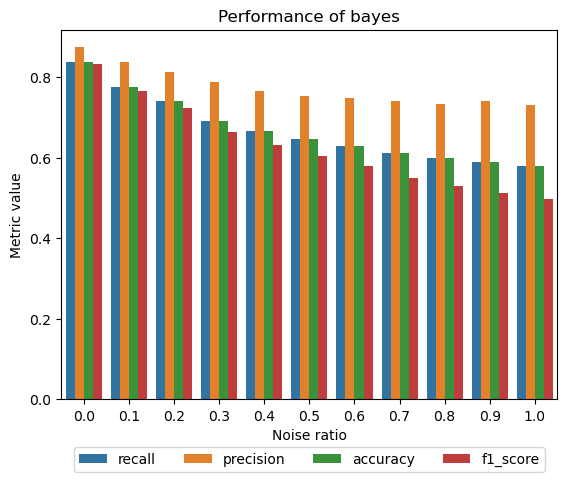

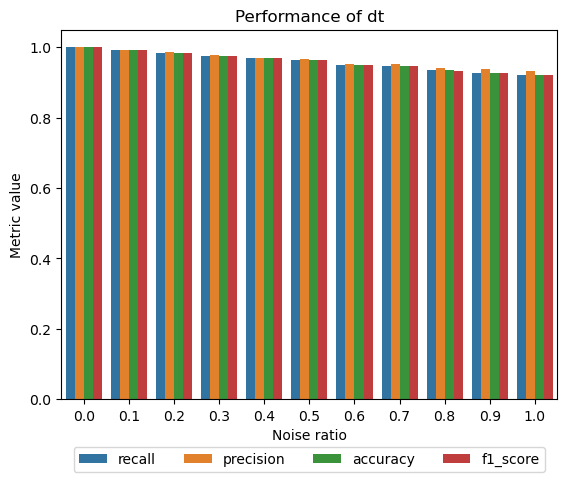

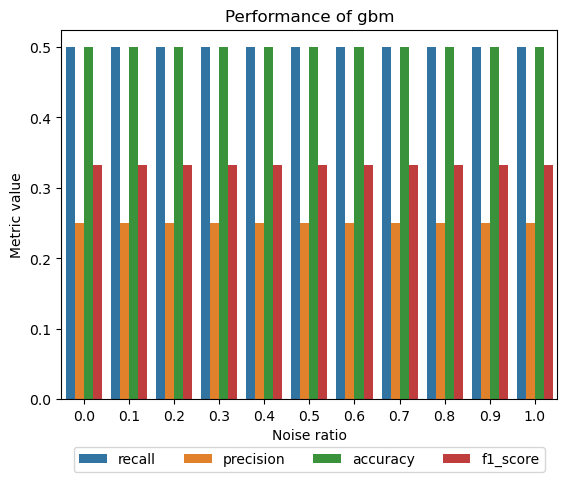

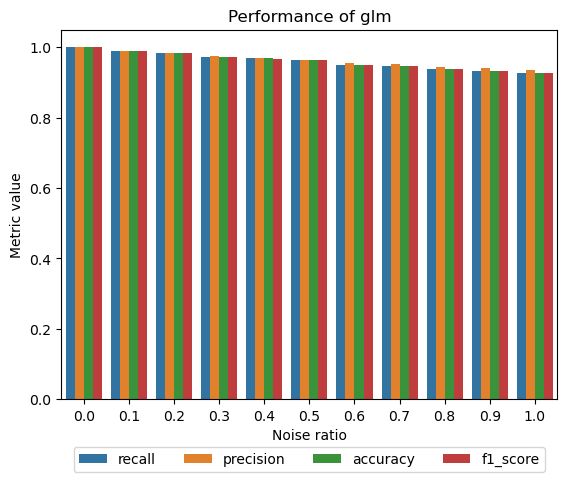

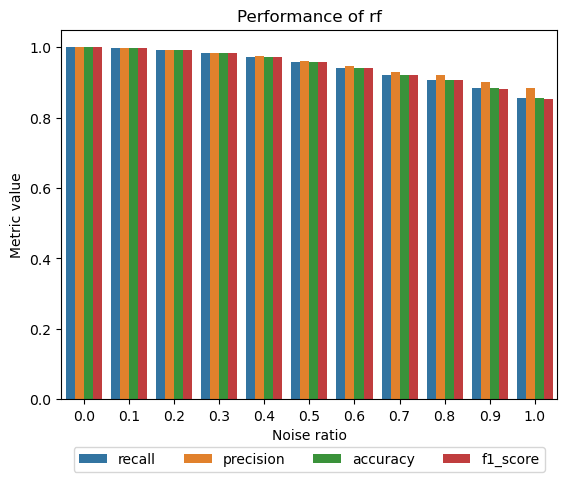

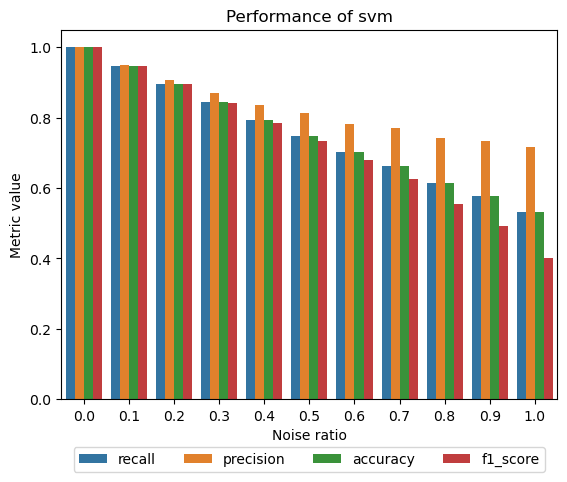

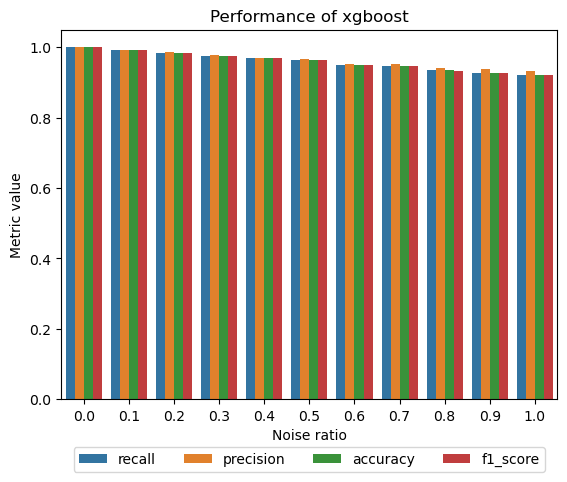

In [16]:
for kind,df_tmp in df_result.groupby("attack"):
    print(kind)
    del df_tmp['attack']
    show_result(df_tmp)